<a href="https://colab.research.google.com/github/alibekk93/IDP_analysis/blob/RAPID/notebooks/04_clustering_and_fIDPnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting UniProt proteomes for Tempura species

## Setup

In [ ]:
!pip install BIO
!sudo apt install clustalw
# !pip install toytree toyplot
!git clone -b RAPID https://github.com/alibekk93/IDP_analysis
!cd /content/IDP_analysis

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
clustalw is already the newest version (2.1+lgpl-7).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Cloning into 'IDP_analysis'...
remote: Enumerating objects: 2586, done.
remote: Counting objects: 100% (1002/1002), done.
remote: Compressing objects: 100% (744/744), done.
remote: Total 2586 (delta 336), reused 831 (delta 254), pack-reused 1584
Receiving objects: 100% (2586/2586), 2.12 GiB | 21.56 MiB/s, done.
Resolving deltas: 100% (1128/1128), done.
Updating files: 100% (734/734), done.


In [ ]:
from IDP_analysis.packages_import import *
from IDP_analysis.idp_in_bacteria_functions import *

In [ ]:
sns.set_theme(context='paper', style='white',  palette='colorblind')

Loading Tempura dataset

In [ ]:
# tempura = pd.read_csv('/content/IDP_analysis/datafiles/tempura/200617_TEMPURA.csv', index_col=0)
# tempura = pd.read_csv('/content/IDP_analysis/datafiles/tempura/tempura_bacteria_uniprot.csv', index_col=0)
tempura = pd.read_csv('/content/IDP_analysis/datafiles/tempura/tempura_filtered.csv', index_col=0)

Only keeping bacteria with available assembly or accession numbers

In [ ]:
# tempura = tempura[tempura['superkingdom']=='Bacteria']
# tempura.dropna(subset='assembly_or_accession', inplace=True)
# tempura.reset_index(drop=True, inplace=True)

Classifying bacteria into groups:
1. Psychrophile: OGT <= 20
2. Mesophile: 20 < OGT <= 40
2. Thermophile: 40 < OGT

While this may be quite liberal, some "psychrohiles" with OGT = 20 have *antarctica* in their species name, so it should be fair enough

Psychrophiles would be dropped from this version

In [ ]:
tempura = tempura[tempura['Topt_ave'] > 20]
tempura['group'] = ['thermophilic' if t >= 40 else 'mesophilic' for t in tempura['Topt_ave']]

Loading all_proteins

In [ ]:
%cd /content/IDP_analysis/datafiles/split_files/
!cat all_proteins.zip.001 all_proteins.zip.002 all_proteins.zip.003 > all_proteins.zip
!unzip all_proteins.zip
!cat all_proteins_filtered.zip.001 all_proteins_filtered.zip.002 all_proteins_filtered.zip.003 > all_proteins_filtered.zip
!unzip all_proteins_filtered.zip
!cat all_proteins_rapid.zip.001 all_proteins_rapid.zip.002 all_proteins_rapid.zip.003 > all_proteins_rapid.zip
!unzip all_proteins_rapid.zip
!cat all_proteins_types.zip.001 all_proteins_types.zip.002 all_proteins_types.zip.003 > all_proteins_types.zip
!unzip all_proteins_types.zip
%cd ../../..

In [ ]:
# all_proteins = pd.read_csv('IDP_analysis/datafiles/split_files/all_proteins.csv', index_col=0)
# all_proteins = pd.read_csv('IDP_analysis/datafiles/split_files/all_proteins_filtered.csv', index_col=0)
# all_proteins = pd.read_csv('IDP_analysis/datafiles/split_files/all_proteins_rapid.csv', index_col=0)
all_proteins = pd.read_csv('IDP_analysis/datafiles/split_files/all_proteins_types.csv', index_col=0)

Merging all_proteins with temura

In [ ]:
all_proteins = all_proteins.merge(tempura, left_on='Species', right_on='genus_and_species')

setting colors

In [ ]:
green = '#1BE434'
red = '#E4341B'

## Clustering all proteins using CD-HIT

In [ ]:
# # saving all proteins to a single fasta file
# with open('/content/all_proteins.fasta', 'w') as fasta_file:
#   for _, row in all_proteins_rapid.iterrows():
#     id = row['ID']
#     seq = row['Sequence']
#     fasta_file.write(f'>{id}\n{seq}\n')

CH-HIT ran on local system using command:
```
cd-hit -i all_proteins.fasta -o all_proteins_70 -c 0.7
```

Importing CD-HIT results

In [ ]:
clustered_proteins_file = '/content/IDP_analysis/datafiles/CD-HIT/all_proteins_70.clstr'

all_proteins['cluster'] = 0
clusters = {}

# Read the clustered proteins file and store clusters
with open(clustered_proteins_file ,'r') as f:
  for line in f:
    if line.startswith('>Cluster'):
      cluster_id = int(line.strip().split()[1])
      clusters[cluster_id] = []
    else:
      protein_id = line.strip().split('>')[1].split('...')[0]
      clusters[cluster_id].append(protein_id)

In [ ]:
protein_cluster_mapping = {cid: proteins for cid, proteins in clusters.items()}
# Reverse cluster dictionary to have ID:cluster
protein_cluster_mapping = {protein_id: cluster for cluster, proteins in protein_cluster_mapping.items() for protein_id in proteins}
# Map clusters to df
all_proteins['cluster'] = all_proteins['ID'].map(protein_cluster_mapping)

We will filter to find clusters that:

1. Have at least 10 different species
2. Have at least 1 disordered protein

We will call these clusters `interesting_clusters` because they are, well, interesting

In [ ]:
cluster_groups = all_proteins.groupby('cluster', as_index=False).agg({'candidate_idp':'max', 'Species':'nunique'})

In [ ]:
min_cluster_size = 10

interesting_cluster_ids = cluster_groups[(cluster_groups['candidate_idp']) & (cluster_groups['Species']>=min_cluster_size)]['cluster']

In [ ]:
len(interesting_clusters)

726

In [ ]:
interesting_clusters = all_proteins[all_proteins['cluster'].isin(interesting_cluster_ids)]
interesting_clusters = interesting_clusters[interesting_clusters['Length'] >= 20]
interesting_clusters.to_csv('interesting_clusters.csv')

Saving all proteins from `interesting_clusters` as `fasta` to predict their disorder using **fIDPnn**


In [ ]:
# !mkdir /content/IDP_analysis/clustered_fastas/

mkdir: cannot create directory ‘/content/IDP_analysis/clustered_fastas/’: File exists


In [ ]:
# # define the maximum sequences per file
# max_sequences_per_file = 430

# # split the DataFrame into chunks of max_sequences_per_file and save as FASTA files
# for i, chunk in enumerate(range(0, len(disordered_clusters), max_sequences_per_file)):
#   chunk_df = disordered_clusters.iloc[chunk:chunk + max_sequences_per_file]
#   # create a FASTA file for the chunk
#   fasta_file_path = f'/content/IDP_analysis/clustered_fastas/clustered_proteins_{i+1}.fasta'
#   with open(fasta_file_path, 'w') as fasta_file:
#     for _, row in chunk_df.iterrows():
#       id = row['ID']
#       seq = row['Sequence']
#       fasta_file.write(f'>{id}\n{seq}\n')

In [ ]:
# !zip -r /content/clustered_fastas.zip /content/IDP_analysis/clustered_fastas -i '*.fasta'
# from google.colab import files
# files.download('/content/clustered_fastas.zip')

  adding: content/IDP_analysis/clustered_fastas/clustered_proteins_4.fasta (deflated 59%)
  adding: content/IDP_analysis/clustered_fastas/clustered_proteins_3.fasta (deflated 62%)
  adding: content/IDP_analysis/clustered_fastas/clustered_proteins_2.fasta (deflated 59%)
  adding: content/IDP_analysis/clustered_fastas/clustered_proteins_1.fasta (deflated 61%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Load fIDPnn results

In [ ]:
interesting_clusters = pd.read_csv('/content/IDP_analysis/datafiles/clusters/interesting_clusters.csv', index_col=0)

In [ ]:
fIDPnn_dfs = {}
df_lines = []

with open('/content/fIDPnn_ALL.csv', 'rb') as f:
  for i, line in enumerate(tqdm(f.readlines())):
    line_decoded = line.decode('utf-8')
    if line_decoded[0] == '>':
      if df_lines != []:
        current_df = pd.DataFrame(np.array(df_lines)[1:, :], columns=np.array(df_lines)[0])
        fIDPnn_dfs[protein_id] = current_df.apply(pd.to_numeric, errors='ignore')
      protein_id = line_decoded[1:-1]
      df_lines = []
    else:
      df_lines.append(line_decoded.strip().split(','))

100%|██████████| 4443230/4443230 [01:31<00:00, 48746.25it/s]


In [ ]:
len(fIDPnn_dfs)

13031

In [ ]:
interesting_clusters.groupby('cluster').size()

cluster
508.0       18
2834.0      11
2865.0      11
3668.0      11
3937.0      11
            ..
946899.0    38
946903.0    16
946977.0    13
947413.0    35
948341.0    17
Length: 616, dtype: int64

In [ ]:
fIDPnn_disorder_list = []
failures = []
interesting_clusters_fIDPnn = interesting_clusters.copy()

for id in tqdm(interesting_clusters['ID']):
  try:
    fIDPnn_disorder_list.append(fIDPnn_dfs[id]['Predicted Score for Disorder'])
  except:
    fIDPnn_disorder_list.append(None)
    failures.append(id)

interesting_clusters['fIDPnn_disorder'] = fIDPnn_disorder_list

100%|██████████| 11476/11476 [00:00<00:00, 68708.34it/s]


In [ ]:
failures

[]

In [ ]:
interesting_clusters_fIDPnn.to_pickle('/content/IDP_analysis/IDP_analysis/datafiles/clusters/interesting_clusters_fIDPnn.pkl')

In [ ]:
# files.download('/content/IDP_analysis/IDP_analysis/datafiles/clusters/interesting_clusters_fIDPnn.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Compare RAPID and fIDPnn

In [ ]:
interesting_clusters_fIDPnn = pd.read_pickle('/content/IDP_analysis/IDP_analysis/datafiles/clusters/interesting_clusters_fIDPnn.pkl')

In [ ]:
X = interesting_clusters['RAPID_disorder']
y = [s.mean() for s in interesting_clusters['fIDPnn_disorder']]

model_comparison_ols = sm.OLS(y, sm.add_constant(X)).fit()

In [ ]:
print(model_comparison_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                 2.704e+04
Date:                Sat, 16 Dec 2023   Prob (F-statistic):               0.00
Time:                        21:03:51   Log-Likelihood:                 10345.
No. Observations:               11476   AIC:                        -2.069e+04
Df Residuals:                   11474   BIC:                        -2.067e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0402      0.001     27.

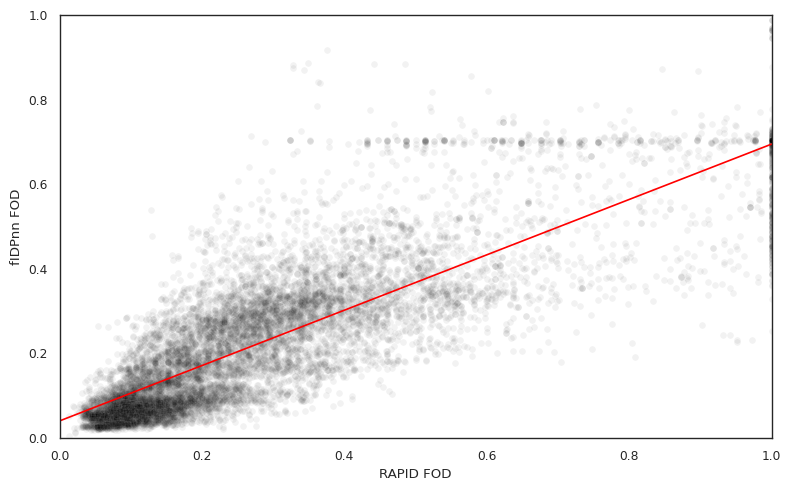

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.scatterplot(x=X, y=y, alpha=0.05, color='black')
ax.plot(model_comparison_ols.predict(sm.add_constant([0, 1])), color='red')

plt.ylabel('fIDPnn FOD')
plt.xlabel('RAPID FOD')
plt.ylim(0, 1)
plt.xlim(0, 1)

plt.tight_layout()
fig.show()
# fig.savefig('RAPID_vs_fIDPnn.svg')

RAPID seems to be an adequate model when compared with fIDPnn, even though it generally does **underpredict** disorder based on coefficient